# Mounting a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import delle Librerie

In [ ]:
# Librerie per la manipolazione e l'analisi dei dati
import pandas as pd
import numpy as np

# Librerie per il deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms                            # Gestione di dataset, modelli pre-addestrati e trasformazioni

# Librerie per la visualizzazione dei dati
import matplotlib.pyplot as plt

# Librerie per la gestione del tempo e del sistema operativo
import time
import os
import shutil                                                                   # Operazioni ad alto livello sui file, come copia e rimozione (usato per splittare i dati)
import sys

# Altre utilità
import scipy.io as sio                                                          # Lavorare con file MATLAB
import copy
import random
from random import shuffle
#from sklearn.model_selection import train_test_split                            # Dividere i dataset in set di allenamento e test
from torch.utils.data import DataLoader, Dataset                                # Gestione dei dataset
from torchsummary import summary
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit                      # Suddividere in modo stratificato i dataset (molto utile, crea un iteratore)
from collections import defaultdict                                             # Dizionari con valori predefiniti
import re                                                                       # Espressioni regolari, ricerca nei testi


# Check sui device

In [ ]:
print("Version: " + str(torch.__version__))
print("Avaible?: " + str(torch.cuda.is_available()))
print("Device: " + str(torch.cuda.get_device_name(0)))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Run GPU?: " + str(device))

Version: 2.3.0+cu121
Avaible?: True
Device: Tesla T4
Run GPU?: cuda:0


# Randomizzazione Deterministica

In [ ]:
# Rendere l'esecuzione deterministica
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Path

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset'
DATASET_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/dataset'
TRAIN_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/train'
VAL_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/val'
TEST_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/test'
COLTURE_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/colture'
WEIGHTS_PATH = '/content/drive/MyDrive/ML/Minicontest3/Weights'
FINAL_WEIGHTS_PATH = '/content/drive/MyDrive/ML/Minicontest3/Weights/Final_Weights'

# Data Visualization

In [ ]:
def list_npy_files(folder_path):
    """
    Elenca i file .npy in una cartella e nelle sue sottocartelle.

    Parameters:
    folder_path (str): Il percorso della cartella da esaminare.

    Returns:
    list: Una lista dei percorsi completi dei file .npy trovati.
    """
    npy_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.npy'):
                npy_files.append(os.path.join(root, file))
    return npy_files

def display_images(npy_files, num_images_to_show=100, reverse_order=False):
    """
    Visualizza le immagini numpy con i canali separati, il nome del file e le dimensioni sotto l'ultima immagine.

    Parameters:
    npy_files (list): Lista dei percorsi dei file .npy.
    num_images_to_show (int): Numero di immagini da visualizzare.
    reverse_order (bool): Se True, ordina i file in ordine alfabetico inverso.
    """
    if reverse_order:
        npy_files.sort(reverse=True)
    else:
        npy_files.sort()

    num_images_to_show = min(num_images_to_show, len(npy_files))                # Ci si assicura di non superare il numero di file disponibili

    plt.figure(figsize=(10, 2 * num_images_to_show))
    channel_titles = ['Channel 1', 'Channel 2', 'Channel 3', 'Original Image']  # Etichette dei canali

    for i in range(num_images_to_show):
        image = np.load(npy_files[i])                                           # Carica l'immagine numpy
        channels = [image[:, :, 0], image[:, :, 1], image[:, :, 2], image]      # Divide l'immagine nei suoi canali
        dimensions = image.shape                                                # Ottieni le dimensioni dell'immagine

        for j, channel in enumerate(channels):
            plt.subplot(num_images_to_show, 4, 4 * i + j + 1)
            plt.imshow(channel, cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(channel_titles[j])

        plt.subplot(num_images_to_show, 4, 4 * i + 4)
        plt.title(os.path.basename(npy_files[i]), fontsize=8)                   # Aggiunge il nome del file come titolo dell'ultimo canale
        plt.axis('off')

    plt.tight_layout()                                                          # Regola automaticamente gli spazi tra subplot
    plt.show()

In [ ]:
NUM_IMAGES_TO_SHOW = 15
REVERSE_ORDER = False

npy_files = list_npy_files(TEST_PATH)

if not npy_files:
    print("No .npy files found in the specified directory.")
else:
    display_images(npy_files, NUM_IMAGES_TO_SHOW, REVERSE_ORDER)

# Data Cleansing

In [ ]:
def move_large_files(base_path, destination_folder, size_threshold_mb=10):
    """
    Scorre le cartelle e sposta i file più grandi di size_threshold_mb in una nuova cartella.

    Parameters:
    base_path (str): Il percorso della cartella principale.
    destination_folder (str): Percorso della cartella di destinazione per i file grandi.
    size_threshold_mb (int): La dimensione in MB sopra la quale i file vengono spostati. Default è 10MB.
    """
    # Assicura che la cartella di destinazione esista
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    size_threshold_bytes = size_threshold_mb * 1024 * 1024  # Converte MB in byte

    for root, dirs, files in os.walk(base_path):
        for file in files:
            file_path = os.path.join(root, file)
            file_size = os.path.getsize(file_path)

            if file_size > size_threshold_bytes:
                # Crea il percorso di destinazione
                relative_path = os.path.relpath(root, base_path)
                destination_path = os.path.join(destination_folder, relative_path)

                if not os.path.exists(destination_path):
                    os.makedirs(destination_path)

                # Sposta il file
                shutil.move(file_path, os.path.join(destination_path, file))
                print(f"Spostato '{file_path}' a '{os.path.join(destination_path, file)}'")

def display_images_from_folder(folder_path):
    """
    Visualizza tutte le immagini numpy di una cartella e delle sue sottocartelle.

    Parameters:
    folder_path (str): Il percorso della cartella contenente le immagini numpy.
    """
    # Estensione dei numpy
    npy_extension = '.npy'

    for root, _, files in os.walk(folder_path):
        # Filtra i file per estensione numpy
        npy_files = [f for f in files if f.lower().endswith(npy_extension)]

        # Visualizza ogni file numpy
        for npy_file in npy_files:
            npy_path = os.path.join(root, npy_file)
            try:
                image = np.load(npy_path)   # Carica il file numpy
                plt.imshow(image)
                plt.title(npy_file)
                plt.axis('off')             # Disabilita gli assi
                plt.show()
            except Exception as e:
                print(f"Errore nell'aprire {npy_file} in {root}: {e}")

In [ ]:
# Rimozione delle colture
move_large_files(DATASET_PATH, COLTURE_PATH)
display_images_from_folder(COLTURE_PATH)

# Randomic Splitting (Holdout)

In [ ]:
def rand_split_dataset(dataset_path, destination_path, val_ratio=0.2, seed=42):
    """
    Divide un dataset in training e validation dividendo le istanze in modo randomico.

    Parameters:
    dataset_path (str): Il percorso del dataset originale.
    destination_path (str): Il percorso della cartella dove salvare i dataset suddivisi.
    val_ratio (float): La proporzione dei file da includere nel set di validation (default è 0.2).
    seed (int): Il seme per il generatore di numeri casuali per garantire la riproducibilità (default è 42).
    """
    # Imposta il seme per la riproducibilità
    random.seed(seed)

    # Percorsi delle cartelle di destinazione
    train_dir = os.path.join(destination_path, 'train')
    val_dir = os.path.join(destination_path, 'val')

    # Crea le cartelle di destinazione se non esistono
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Elenco dei file nel dataset, comprese le sottocartelle
    files = []
    for root, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            files.append(os.path.join(root, filename))

    # Mescola i file e dividili in due insiemi
    random.shuffle(files)
    split_point = int(len(files) * val_ratio)
    val_files = files[:split_point]
    train_files = files[split_point:]

    # Sposta i file nelle cartelle di destinazione con barra di avanzamento
    print("Spostamento dei file nella cartella 'train':")
    for file in tqdm(train_files, desc="Train files"):
        # Calcola il percorso di destinazione mantenendo la struttura delle sottocartelle
        rel_path = os.path.relpath(file, dataset_path)
        dest_path = os.path.join(train_dir, rel_path)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.move(file, dest_path)

    print("Spostamento dei file nella cartella 'val':")
    for file in tqdm(val_files, desc="Validation files"):
        # Calcola il percorso di destinazione mantenendo la struttura delle sottocartelle
        rel_path = os.path.relpath(file, dataset_path)
        dest_path = os.path.join(val_dir, rel_path)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.move(file, dest_path)

    print(f"Dataset suddiviso: {len(train_files)} file in 'train', {len(val_files)} file in 'val'")

In [ ]:
rand_split_dataset(DATASET_PATH, DATA_PATH, val_ratio=0.25, seed=42)


Spostamento dei file nella cartella 'train_2':


Train files: 100%|██████████| 3670/3670 [00:14<00:00, 258.67it/s]


Spostamento dei file nella cartella 'val_2':


Validation files: 100%|██████████| 1223/1223 [00:04<00:00, 244.74it/s]

Dataset suddiviso: 3670 file in 'train_2', 1223 file in 'val_2'


# Strartified Splitting (Holdout)

In [ ]:
def split_dataset(dataset_path, destination_path, val_ratio=0.25, seed=42):
    """
    Divide un dataset in training e validation dividendo le istanze in modo stratificato.

    Parameters:
    dataset_path (str): Il percorso del dataset originale.
    destination_path (str): Il percorso della cartella dove salvare i dataset suddivisi.
    val_ratio (float): La proporzione dei file da includere nel set di validation (default è 0.2).
    seed (int): Il seme per il generatore di numeri casuali per garantire la riproducibilità (default è 42).
    """
    # Imposta il seme per la riproducibilità
    random.seed(seed)

    # Percorsi delle cartelle di destinazione
    train_dir = os.path.join(destination_path, 'train')
    val_dir = os.path.join(destination_path, 'val')

    # Crea le cartelle di destinazione se non esistono
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Elenco dei file nel dataset, comprese le sottocartelle
    files = []
    labels = []
    for root, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
            # Assumi che le classi siano rappresentate dalle sottocartelle
            labels.append(os.path.basename(root))

    # Utilizza StratifiedShuffleSplit per dividere i file in modo stratificato
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=seed)
    train_indices, val_indices = next(strat_split.split(files, labels))

    train_files = [files[i] for i in train_indices]
    val_files = [files[i] for i in val_indices]

    # Funzione per spostare i file nelle cartelle di destinazione mantenendo la struttura delle sottocartelle
    def move_files(file_list, dest_dir):
        for file in tqdm(file_list, desc=f"Moving files to {dest_dir}"):
            rel_path = os.path.relpath(file, dataset_path)
            dest_path = os.path.join(dest_dir, rel_path)
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            shutil.move(file, dest_path)

    # Sposta i file nelle cartelle di destinazione
    print("Spostamento dei file nella cartella 'train':")
    move_files(train_files, train_dir)

    print("Spostamento dei file nella cartella 'val':")
    move_files(val_files, val_dir)

    print(f"Dataset suddiviso: {len(train_files)} file in 'train', {len(val_files)} file in 'val'")


In [ ]:
split_dataset(DATASET_PATH, DATA_PATH, val_ratio=0.25, seed=42)

Spostamento dei file nella cartella 'train_3':


Moving files to /content/drive/MyDrive/ML/Minicontest3/Dataset/train_3: 100%|██████████| 3669/3669 [00:16<00:00, 227.01it/s]


Spostamento dei file nella cartella 'val_3':


Moving files to /content/drive/MyDrive/ML/Minicontest3/Dataset/val_3: 100%|██████████| 1224/1224 [00:05<00:00, 214.02it/s]

Dataset suddiviso: 3669 file in 'train_3', 1224 file in 'val_3'


# Data Loader e Trasformazioni


In [ ]:
# Dimensione del batch
batch_size = 32

In [ ]:
# Definizione della classe My_DatasetFolder
class My_DatasetFolder(Dataset):
    def __init__(self, root, transform, is_valid_file, list_classes):
        self.root = root
        self.transform = transform
        self.is_valid_file = is_valid_file
        self.list_classes = list_classes
        self.samples = self.__get_samples()

    def __len__(self):
        return len(self.samples)

    def __get_samples(self):
        ListFiles = []
        for c in self.list_classes:
            list_folder = os.listdir(self.root + '/' + c)
            for folder in list_folder:
                listofFiles = os.listdir(self.root + '/' + c + '/' + folder)
                for file in listofFiles:
                    if self.is_valid_file(self.root + '/' + c + '/' + folder + '/' + file):
                        ListFiles.append((self.root + '/' + c + '/' + folder + '/' + file, self.list_classes.index(c)))
        return ListFiles

    def loader_fc(self, path):
        img = np.load(path)
        return img

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        sample = self.loader_fc(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [ ]:
# Trasformazioni dei dati per i set di addestramento e di validazione
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),           # Ruota casualmente le immagini di un angolo fino a 10 gradi
        transforms.Resize(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
is_valid_file = lambda path: path.endswith('.npy')

# Creaazione del dataset di addestramento e di validazione utilizzando My_DatasetFolder
train_dataset = My_DatasetFolder(root=TRAIN_PATH, transform=data_transforms['train'], is_valid_file=is_valid_file, list_classes=['benign', 'malignant'])
val_dataset = My_DatasetFolder(root=VAL_PATH, transform=data_transforms['val'], is_valid_file=is_valid_file, list_classes=['benign', 'malignant'])

# Creazione del DataLoader per i set di addestramento e di validazione
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# Stampa della dimensione dei dataset di training e validation
train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)
print("Dimensione del dataset di addestramento:", train_dataset_size)
print("Dimensione del dataset di validazione:", val_dataset_size)

Dimensione del dataset di addestramento: 3669
Dimensione del dataset di validazione: 1224


# Traning e Validation

In [ ]:
def train_loop_validation(train_dataloader, val_dataloader, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv, best_acc, best_loss, best_epoca, outputPath):
    # Cancella i file di testo esistenti, se presenti
    train_files = ['lossTrain.txt', 'AccTrain.txt', 'lossVal.txt', 'AccVal.txt']
    for filename in train_files:
        filepath = os.path.join(outputPath, filename)
        if os.path.exists(filepath):
            os.remove(filepath)

    # Training loop
    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Mini-Batch Loop
        for inputs, labels in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Training"):
            inputs = inputs.float().to(device)
            labels = labels.view(-1, 1).float().to(device)  # Converto le label in float per la BCE e faccio reshape

            optimizer_conv.zero_grad()                # Resetta i gradienti dell'ottimizzatore
            outputs = model_conv(inputs)              # Propagazione feed-forward
            lossCNN = criterionCNN(outputs, labels)   # Calcola la loss
            lossCNN.backward()                        # Propagazione all'indietro
            optimizer_conv.step()                     # Aggiorna i pesi

            modelLoss_train += lossCNN.item() * inputs.size(0)    # Accumula la loss pesata per il numero di campioni
            totalSize += inputs.size(0)                           # Aggiorna il conteggio totale dei campioni

            # Predizioni sul train
            # Applica la sigmoide e arrotonda
            preds = torch.sigmoid(outputs).round()
            modelAcc_train += torch.sum(preds == labels.data).item()

        modelLoss_epoch_train = modelLoss_train / totalSize   # Loss media per epoca
        modelAcc_epoch_train = modelAcc_train / totalSize     # Accuratezza media per epoca

        # Validation loop
        model_conv.eval()
        totalSize_val = 0
        modelLoss_val = 0.0
        modelAcc_val = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_dataloader, total=len(val_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Validation"):
                inputs = inputs.float().to(device)
                labels = labels.view(-1, 1).float().to(device)

                outputs = model_conv(inputs)
                lossCNN = criterionCNN(outputs, labels)

                modelLoss_val += lossCNN.item() * inputs.size(0)
                totalSize_val += inputs.size(0)

                preds = torch.sigmoid(outputs).round()
                modelAcc_val += torch.sum(preds == labels.data).item()

        modelLoss_epoch_val = modelLoss_val / totalSize_val
        modelAcc_epoch_val = modelAcc_val / totalSize_val
        time_elapsed = time.time() - since

        current_lr = optimizer_conv.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, modelLoss_epoch_train, modelAcc_epoch_train, totalSize_val, modelLoss_epoch_val,
                 modelAcc_epoch_val, time_elapsed // 60, time_elapsed % 60, current_lr))

        # Salva il miglior modello
        if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss):
            print('     .... Saving best weights ....')
            best_acc = modelAcc_epoch_val
            best_loss = modelLoss_epoch_val
            best_epoca = epoch
            torch.save(model_conv.state_dict(), os.path.join(outputPath, 'best_model_weights.pth'))

        # Logging delle loss e dell'accuracy
        with open(os.path.join(outputPath, 'lossTrain.txt'), "a") as file_object:
            file_object.write(str(modelLoss_epoch_train) + '\n')

        with open(os.path.join(outputPath, 'AccTrain.txt'), "a") as file_object:
            file_object.write(str(modelAcc_epoch_train) + '\n')

        with open(os.path.join(outputPath, 'lossVal.txt'), "a") as file_object:
            file_object.write(str(modelLoss_epoch_val) + '\n')

        with open(os.path.join(outputPath, 'AccVal.txt'), "a") as file_object:
            file_object.write(str(modelAcc_epoch_val) + '\n')

        sio.savemat(os.path.join(outputPath, 'check_point.mat'), {'best_acc': best_acc,
                                                                  'best_loss': best_loss,
                                                                  'best_epoca': best_epoca,
                                                                  'last_epoch': epoch})

    return best_epoca

In [ ]:
# Definisce il modello
model_conv = models.resnet50(pretrained=True).cuda()

# Stampa il summary del modello
summary(model_conv, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Iperparametri
learning_rate = 0.001
num_epochs = 30
startEpoch = 1
best_acc = 0.0
best_loss = float('inf')
best_epoch = -1

# Ridefinizione del modello per evitare sovrascrizioni al nuovo lancio
model_conv = models.resnet50(pretrained=True).cuda()

# Sostituire l'ultimo layer per la classificazione binaria
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 1).cuda()

# Congela solo i parametri dei primi blocchi del modello
for name, param in model_conv.named_parameters():
    if 'layer4' not in name and 'layer3' not in name and 'fc' not in name:
        param.requires_grad = False

# Definire criterio e ottimizzatore
criterionCNN = nn.BCEWithLogitsLoss().cuda()
optimizer_conv = optim.Adam(filter(lambda p: p.requires_grad, model_conv.parameters()), lr=learning_rate)

In [ ]:
# Chiamata alla funzione di training con validazione
best_epoch = train_loop_validation(train_dataloader, val_dataloader, startEpoch, num_epochs, model_conv, criterionCNN, optimizer_conv, best_acc, best_loss, best_epoch, WEIGHTS_PATH)

Epoch 1/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.17it/s]


[Epoch 1][TRAIN on 3669 [Loss: 0.3524  ACC: 0.8591]][VAL on 1224 [Loss: 0.4313  ACC: 0.8538]][TIME: 0 m 44 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 2/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.33it/s]


[Epoch 2][TRAIN on 3669 [Loss: 0.2635  ACC: 0.9005]][VAL on 1224 [Loss: 0.2155  ACC: 0.9191]][TIME: 0 m 40 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 3/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.26it/s]


[Epoch 3][TRAIN on 3669 [Loss: 0.2210  ACC: 0.9139]][VAL on 1224 [Loss: 0.3264  ACC: 0.8824]][TIME: 0 m 42 s] [LR: 0.00100]


Epoch 4/30 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.72it/s]


[Epoch 4][TRAIN on 3669 [Loss: 0.1988  ACC: 0.9193]][VAL on 1224 [Loss: 0.2317  ACC: 0.9093]][TIME: 0 m 41 s] [LR: 0.00100]


Epoch 5/30 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.71it/s]


[Epoch 5][TRAIN on 3669 [Loss: 0.1900  ACC: 0.9240]][VAL on 1224 [Loss: 0.1928  ACC: 0.9306]][TIME: 0 m 42 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 6/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.17it/s]


[Epoch 6][TRAIN on 3669 [Loss: 0.1653  ACC: 0.9324]][VAL on 1224 [Loss: 0.2117  ACC: 0.9265]][TIME: 0 m 43 s] [LR: 0.00100]


Epoch 7/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.22it/s]


[Epoch 7][TRAIN on 3669 [Loss: 0.1559  ACC: 0.9422]][VAL on 1224 [Loss: 0.1693  ACC: 0.9355]][TIME: 0 m 42 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 8/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.30it/s]


[Epoch 8][TRAIN on 3669 [Loss: 0.1471  ACC: 0.9414]][VAL on 1224 [Loss: 0.1808  ACC: 0.9314]][TIME: 0 m 43 s] [LR: 0.00100]


Epoch 9/30 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.52it/s]


[Epoch 9][TRAIN on 3669 [Loss: 0.1382  ACC: 0.9490]][VAL on 1224 [Loss: 0.1395  ACC: 0.9493]][TIME: 0 m 42 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 10/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.31it/s]


[Epoch 10][TRAIN on 3669 [Loss: 0.1256  ACC: 0.9493]][VAL on 1224 [Loss: 0.1578  ACC: 0.9371]][TIME: 0 m 40 s] [LR: 0.00100]


Epoch 11/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s]


[Epoch 11][TRAIN on 3669 [Loss: 0.1277  ACC: 0.9528]][VAL on 1224 [Loss: 0.1549  ACC: 0.9412]][TIME: 0 m 42 s] [LR: 0.00100]


Epoch 12/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.04it/s]


[Epoch 12][TRAIN on 3669 [Loss: 0.1278  ACC: 0.9528]][VAL on 1224 [Loss: 0.1577  ACC: 0.9379]][TIME: 0 m 43 s] [LR: 0.00100]


Epoch 13/30 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.44it/s]


[Epoch 13][TRAIN on 3669 [Loss: 0.1086  ACC: 0.9605]][VAL on 1224 [Loss: 0.1166  ACC: 0.9485]][TIME: 0 m 42 s] [LR: 0.00100]


Epoch 14/30 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.33it/s]


[Epoch 14][TRAIN on 3669 [Loss: 0.1214  ACC: 0.9548]][VAL on 1224 [Loss: 0.1266  ACC: 0.9518]][TIME: 0 m 42 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 15/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.35it/s]


[Epoch 15][TRAIN on 3669 [Loss: 0.1060  ACC: 0.9621]][VAL on 1224 [Loss: 0.1568  ACC: 0.9428]][TIME: 0 m 41 s] [LR: 0.00100]


Epoch 16/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.12it/s]


[Epoch 16][TRAIN on 3669 [Loss: 0.0942  ACC: 0.9667]][VAL on 1224 [Loss: 0.1649  ACC: 0.9412]][TIME: 0 m 42 s] [LR: 0.00100]


Epoch 17/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.14it/s]


[Epoch 17][TRAIN on 3669 [Loss: 0.0904  ACC: 0.9635]][VAL on 1224 [Loss: 0.1320  ACC: 0.9404]][TIME: 0 m 40 s] [LR: 0.00100]


Epoch 18/30 - Validation: 100%|██████████| 39/39 [00:11<00:00,  3.45it/s]


[Epoch 18][TRAIN on 3669 [Loss: 0.0896  ACC: 0.9681]][VAL on 1224 [Loss: 0.1642  ACC: 0.9379]][TIME: 0 m 44 s] [LR: 0.00100]


Epoch 19/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  4.90it/s]


[Epoch 19][TRAIN on 3669 [Loss: 0.0935  ACC: 0.9643]][VAL on 1224 [Loss: 0.1331  ACC: 0.9453]][TIME: 0 m 41 s] [LR: 0.00100]


Epoch 20/30 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


[Epoch 20][TRAIN on 3669 [Loss: 0.0972  ACC: 0.9646]][VAL on 1224 [Loss: 0.1395  ACC: 0.9534]][TIME: 0 m 42 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 21/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.11it/s]


[Epoch 21][TRAIN on 3669 [Loss: 0.0786  ACC: 0.9719]][VAL on 1224 [Loss: 0.1140  ACC: 0.9567]][TIME: 0 m 43 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 22/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.21it/s]


[Epoch 22][TRAIN on 3669 [Loss: 0.0808  ACC: 0.9689]][VAL on 1224 [Loss: 0.1415  ACC: 0.9485]][TIME: 0 m 41 s] [LR: 0.00100]


Epoch 23/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.19it/s]


[Epoch 23][TRAIN on 3669 [Loss: 0.0791  ACC: 0.9722]][VAL on 1224 [Loss: 0.1973  ACC: 0.9158]][TIME: 0 m 42 s] [LR: 0.00100]


Epoch 24/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.33it/s]


[Epoch 24][TRAIN on 3669 [Loss: 0.0778  ACC: 0.9700]][VAL on 1224 [Loss: 0.1404  ACC: 0.9510]][TIME: 0 m 42 s] [LR: 0.00100]


Epoch 25/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.11it/s]


[Epoch 25][TRAIN on 3669 [Loss: 0.0701  ACC: 0.9703]][VAL on 1224 [Loss: 0.1603  ACC: 0.9346]][TIME: 0 m 42 s] [LR: 0.00100]


Epoch 26/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.16it/s]


[Epoch 26][TRAIN on 3669 [Loss: 0.0770  ACC: 0.9733]][VAL on 1224 [Loss: 0.1730  ACC: 0.9404]][TIME: 0 m 40 s] [LR: 0.00100]


Epoch 27/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s]


[Epoch 27][TRAIN on 3669 [Loss: 0.0668  ACC: 0.9744]][VAL on 1224 [Loss: 0.1518  ACC: 0.9559]][TIME: 0 m 41 s] [LR: 0.00100]


Epoch 28/30 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


[Epoch 28][TRAIN on 3669 [Loss: 0.0684  ACC: 0.9763]][VAL on 1224 [Loss: 0.1384  ACC: 0.9493]][TIME: 0 m 42 s] [LR: 0.00100]


Epoch 29/30 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.10it/s]


[Epoch 29][TRAIN on 3669 [Loss: 0.0667  ACC: 0.9730]][VAL on 1224 [Loss: 0.1268  ACC: 0.9534]][TIME: 0 m 40 s] [LR: 0.00100]


Epoch 30/30 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s]


[Epoch 30][TRAIN on 3669 [Loss: 0.0675  ACC: 0.9763]][VAL on 1224 [Loss: 0.1141  ACC: 0.9624]][TIME: 0 m 45 s] [LR: 0.00100]
     .... Saving best weights ....


# Metrics Plot

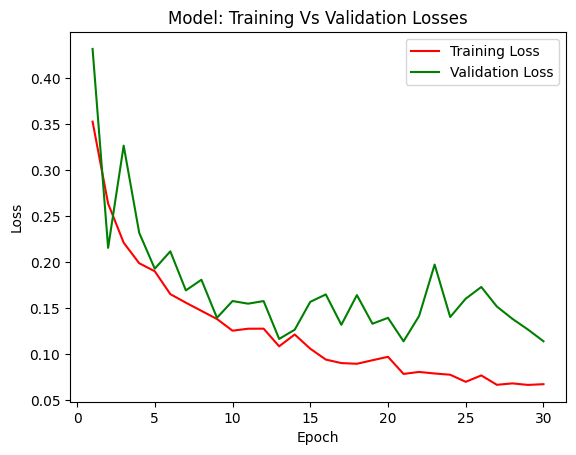

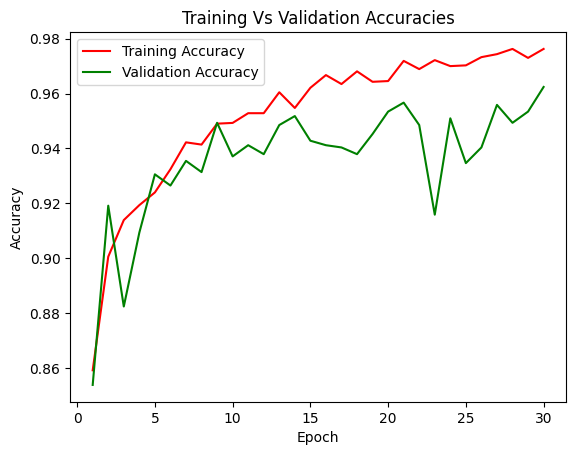

In [ ]:
# Inizializzazione delle liste per le perdite e le accuratezze
lossModel_Train = []
lossModel_val = []
accModel_Train = []
accModel_val = []

# Lettura dei file di perdita del training
loss_train_path = os.path.join(WEIGHTS_PATH, 'lossTrain.txt')
with open(loss_train_path, 'r') as file:
    lossModel_Train = [float(line.strip()) for line in file.readlines()]

# Lettura dei file di perdita della validazione
loss_val_path = os.path.join(WEIGHTS_PATH, 'lossVal.txt')
with open(loss_val_path, 'r') as file:
    lossModel_val = [float(line.strip()) for line in file.readlines()]

# Plot delle perdite di training e validazione
plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, len(lossModel_Train) + 1), lossModel_Train, color='r', label="Training Loss")
plt.plot(range(1, len(lossModel_val) + 1), lossModel_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'LossTrainVal.png'))

# Lettura dei file di accuratezza del training
acc_train_path = os.path.join(WEIGHTS_PATH, 'AccTrain.txt')
with open(acc_train_path, 'r') as file:
    accModel_Train = [float(line.strip()) for line in file.readlines()]

# Lettura dei file di accuratezza della validazione
acc_val_path = os.path.join(WEIGHTS_PATH, 'AccVal.txt')
with open(acc_val_path, 'r') as file:
    accModel_val = [float(line.strip()) for line in file.readlines()]

# Plot delle accuratezze di training e validazione
plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, len(accModel_Train) + 1), accModel_Train, color='r', label="Training Accuracy")
plt.plot(range(1, len(accModel_val) + 1), accModel_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'AccTrainVal.png'))

# Trasformazioni e dataloader del training finale

In [ ]:
is_valid_file = lambda path: path.endswith('.npy')

# Creaazione del dataset di addestramento e di validazione utilizzando My_DatasetFolder
final_dataset = My_DatasetFolder(root=DATASET_PATH, transform=data_transforms['train'], is_valid_file=is_valid_file, list_classes=['benign', 'malignant'])

# Creazione del DataLoader per i set di addestramento e di validazione
final_dataloader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
# Stampa della dimensione dei dataset di training e validation
final_dataset_size = len(final_dataset)
print("Dimensione del dataset:", final_dataset_size)

Dimensione del dataset: 4893


# Training Finale

In [ ]:
def train_loop(train_dataloader, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv, outputPath):
    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Numero totale di batch
        total_batches = len(train_dataloader)

        # Training loop
        for batch_idx, (inputs, labels) in enumerate(tqdm(train_dataloader, total=total_batches)):
            inputs = inputs.float().cuda()
            labels = labels.view(-1, 1).float().cuda()

            optimizer_conv.zero_grad()

            outputs = model_conv(inputs)
            lossCNN = criterionCNN(outputs, labels)
            lossCNN.backward()
            optimizer_conv.step()

            modelLoss_train += lossCNN.item() * inputs.size(0)
            totalSize += inputs.size(0)

            preds = torch.sigmoid(outputs).round()
            modelAcc_train += torch.sum(preds == labels.data).item()

        modelLoss_epoch_train = modelLoss_train / totalSize
        modelAcc_epoch_train = modelAcc_train / totalSize

        # Salva i pesi
        torch.save(model_conv.state_dict(), outputPath + '/weights.pth'.format(epoch))

        time_elapsed = time.time() - since

        # Ottieni il learning rate
        current_lr = optimizer_conv.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, modelLoss_epoch_train, modelAcc_epoch_train, time_elapsed // 60, time_elapsed % 60, current_lr))

        # Logging losses and accuracies
        with open(outputPath + '/lossTrain.txt', "a") as file_object:
            file_object.write(str(modelLoss_epoch_train) + '\n')

        with open(outputPath + '/AccTrain.txt', "a") as file_object:
            file_object.write(str(modelAcc_epoch_train) + '\n')

In [ ]:
# Iperparametri aggiornati
learning_rate = 0.001
startEpoch = 1
best_epoch = 21

# Ridefinizione del modello per evitare sovrascrizioni
model_conv = models.resnet50(pretrained=True).cuda()

# Sostituire l'ultimo layer per la classificazione binaria
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 1).cuda()

# Congela solo i parametri dei primi blocchi del modello
for name, param in model_conv.named_parameters():
    if 'layer4' not in name and 'layer3' not in name and 'fc' not in name:
        param.requires_grad = False

# Definire criterio e ottimizzatore
criterionCNN = nn.BCEWithLogitsLoss().cuda()
optimizer_conv = optim.Adam(filter(lambda p: p.requires_grad, model_conv.parameters()), lr=learning_rate)

In [ ]:
train_loop(final_dataloader, startEpoch, best_epoch, model_conv, criterionCNN, optimizer_conv, FINAL_WEIGHTS_PATH)

100%|██████████| 153/153 [28:17<00:00, 11.10s/it]


[Epoch 1][TRAIN on 4893 [Loss: 0.3289  ACC: 0.8731]][TIME: 28 m 24 s] [LR: 0.00100]


100%|██████████| 153/153 [00:49<00:00,  3.08it/s]


[Epoch 2][TRAIN on 4893 [Loss: 0.2363  ACC: 0.9080]][TIME: 0 m 50 s] [LR: 0.00100]


100%|██████████| 153/153 [00:49<00:00,  3.12it/s]


[Epoch 3][TRAIN on 4893 [Loss: 0.2050  ACC: 0.9183]][TIME: 0 m 49 s] [LR: 0.00100]


100%|██████████| 153/153 [00:51<00:00,  3.00it/s]


[Epoch 4][TRAIN on 4893 [Loss: 0.1645  ACC: 0.9403]][TIME: 0 m 51 s] [LR: 0.00100]


100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


[Epoch 5][TRAIN on 4893 [Loss: 0.1534  ACC: 0.9413]][TIME: 0 m 51 s] [LR: 0.00100]


100%|██████████| 153/153 [00:50<00:00,  3.02it/s]


[Epoch 6][TRAIN on 4893 [Loss: 0.1450  ACC: 0.9432]][TIME: 0 m 51 s] [LR: 0.00100]


100%|██████████| 153/153 [00:58<00:00,  2.62it/s]


[Epoch 7][TRAIN on 4893 [Loss: 0.1286  ACC: 0.9510]][TIME: 0 m 59 s] [LR: 0.00100]


100%|██████████| 153/153 [00:48<00:00,  3.18it/s]


[Epoch 8][TRAIN on 4893 [Loss: 0.1221  ACC: 0.9524]][TIME: 0 m 48 s] [LR: 0.00100]


100%|██████████| 153/153 [00:49<00:00,  3.11it/s]


[Epoch 9][TRAIN on 4893 [Loss: 0.1142  ACC: 0.9579]][TIME: 0 m 50 s] [LR: 0.00100]


100%|██████████| 153/153 [00:55<00:00,  2.75it/s]


[Epoch 10][TRAIN on 4893 [Loss: 0.0990  ACC: 0.9644]][TIME: 0 m 56 s] [LR: 0.00100]


100%|██████████| 153/153 [00:50<00:00,  3.02it/s]


[Epoch 11][TRAIN on 4893 [Loss: 0.0977  ACC: 0.9630]][TIME: 0 m 51 s] [LR: 0.00100]


100%|██████████| 153/153 [00:52<00:00,  2.93it/s]


[Epoch 12][TRAIN on 4893 [Loss: 0.0914  ACC: 0.9628]][TIME: 0 m 53 s] [LR: 0.00100]


100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


[Epoch 13][TRAIN on 4893 [Loss: 0.0834  ACC: 0.9681]][TIME: 0 m 51 s] [LR: 0.00100]


100%|██████████| 153/153 [00:54<00:00,  2.80it/s]


[Epoch 14][TRAIN on 4893 [Loss: 0.0853  ACC: 0.9679]][TIME: 0 m 55 s] [LR: 0.00100]


100%|██████████| 153/153 [00:51<00:00,  2.94it/s]


[Epoch 15][TRAIN on 4893 [Loss: 0.0763  ACC: 0.9720]][TIME: 0 m 52 s] [LR: 0.00100]


100%|██████████| 153/153 [00:48<00:00,  3.18it/s]


[Epoch 16][TRAIN on 4893 [Loss: 0.0706  ACC: 0.9738]][TIME: 0 m 48 s] [LR: 0.00100]


100%|██████████| 153/153 [00:51<00:00,  2.96it/s]


[Epoch 17][TRAIN on 4893 [Loss: 0.0714  ACC: 0.9740]][TIME: 0 m 52 s] [LR: 0.00100]


100%|██████████| 153/153 [00:48<00:00,  3.16it/s]


[Epoch 18][TRAIN on 4893 [Loss: 0.0633  ACC: 0.9755]][TIME: 0 m 49 s] [LR: 0.00100]


100%|██████████| 153/153 [00:48<00:00,  3.18it/s]


[Epoch 19][TRAIN on 4893 [Loss: 0.0599  ACC: 0.9773]][TIME: 0 m 48 s] [LR: 0.00100]


100%|██████████| 153/153 [00:49<00:00,  3.10it/s]


[Epoch 20][TRAIN on 4893 [Loss: 0.0601  ACC: 0.9771]][TIME: 0 m 50 s] [LR: 0.00100]


100%|██████████| 153/153 [00:55<00:00,  2.77it/s]


[Epoch 21][TRAIN on 4893 [Loss: 0.0615  ACC: 0.9761]][TIME: 0 m 55 s] [LR: 0.00100]


100%|██████████| 153/153 [00:51<00:00,  2.94it/s]


[Epoch 22][TRAIN on 4893 [Loss: 0.0673  ACC: 0.9738]][TIME: 0 m 52 s] [LR: 0.00100]


100%|██████████| 153/153 [00:50<00:00,  3.05it/s]


[Epoch 23][TRAIN on 4893 [Loss: 0.0496  ACC: 0.9822]][TIME: 0 m 51 s] [LR: 0.00100]


100%|██████████| 153/153 [00:50<00:00,  3.06it/s]


[Epoch 24][TRAIN on 4893 [Loss: 0.0497  ACC: 0.9828]][TIME: 0 m 50 s] [LR: 0.00100]


100%|██████████| 153/153 [00:47<00:00,  3.21it/s]


[Epoch 25][TRAIN on 4893 [Loss: 0.0428  ACC: 0.9834]][TIME: 0 m 48 s] [LR: 0.00100]


 # Predizioni del Test e creazione del CSV

In [ ]:
class My_DatasetFolder_Test(Dataset):
    def __init__(self, root, transform=None, is_valid_file=None):
        self.root = root
        self.transform = transform
        self.is_valid_file = is_valid_file
        self.samples = self.__get_samples()

    def __len__(self):
        return len(self.samples)

    def __get_samples(self):
        ListFiles = []
        list_files = os.listdir(self.root)
        for file_name in list_files:
            if self.is_valid_file(os.path.join(self.root, file_name)):
                ListFiles.append((os.path.join(self.root, file_name), 0))
        return ListFiles

    def loader_fc(self, path):
        img = np.load(path)
        return img

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        sample = self.loader_fc(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [ ]:
def extract_number_from_path(path):
    # Estrae il numero dal percorso usando un'espressione regolare
    match = re.search(r'/(\d+)\.npy$', path)
    if match:
        return int(match.group(1))
    else:
        return float('inf')  # Ritorna infinito se non viene trovato alcun numero

def prepare_test_dataset(test_path, transform, is_valid_file, device):
    test_data = My_DatasetFolder_Test(root=test_path, transform=transform, is_valid_file=is_valid_file)

    # Ottieni i percorsi dei file invece dei dati trasformati
    test_file_paths = [sample[0] for sample in test_data.samples]

    # Ordina i percorsi dei file in base al numero presente in ciascun percorso
    test_file_paths_sorted = sorted(test_file_paths, key=extract_number_from_path)

    return test_file_paths_sorted

In [ ]:
is_valid_file = lambda path: path.endswith('.npy')
test_file_paths = prepare_test_dataset(TEST_PATH, data_transforms['val'], is_valid_file, device)

In [ ]:
def predict_and_save(model, model_weights_path, test_file_paths, transform, output_csv, device):
    # Carica i pesi del modello e convertili in FloatTensor
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    model.to(device)
    model.eval()

    # Funzione di sigmoid
    sigmoid = nn.Sigmoid()

    results = []

    # Per ogni immagine nel test set
    for img_path in test_file_paths:
        # Carica l'immagine dal file path
        img = np.load(img_path)

        # Applica le trasformazioni
        img_tensor = transform(img).float().to(device)  # Applica le trasformazioni direttamente

        # Verifica l'ordine delle dimensioni e correggilo se necessario
        if img_tensor.shape[0] != 3:
            img_tensor = img_tensor.permute(2, 0, 1)  # Assicurati che l'ordine delle dimensioni sia (C, H, W)

        with torch.no_grad():
            pred = model(img_tensor.unsqueeze(0))  # Aggiungi una dimensione iniziale per il batch
            prob = sigmoid(pred)

        # Ottiene la classe predetta
        predicted_class = 'malignant' if prob.item() > 0.5 else 'benign'

        # Ottieni l'ID dall'immagine
        img_name = os.path.basename(img_path)
        img_id, _ = os.path.splitext(img_name)

        # Salva il risultato
        results.append((img_id + '.npy', predicted_class))

    # Crea un DataFrame
    df = pd.DataFrame(results, columns=['ID', 'Class'])

    # Salva il DataFrame nel file CSV sovrascrivendo il file esistente, se presente
    df.to_csv(output_csv, index=False, mode='w')

In [ ]:
predict_and_save(model_conv, FINAL_WEIGHTS_PATH + '/weights.pth', test_file_paths, data_transforms['val'], DATA_PATH + '/final_prediction.csv', device)